# Benchmarking

In [20]:
import dask.dataframe as dd
import numpy as np
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import functools

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:55857")
client

<Client: 'tcp://127.0.0.1:55857' processes=4 threads=8, memory=16.00 GiB>

# Dask.dataframe

In [12]:
%%time
df = dd.read_parquet("../data/process/gdp_v2.00-obs-dask")

CPU times: user 5.67 ms, sys: 6.63 ms, total: 12.3 ms
Wall time: 15 ms


## Geographical binning of any variable (SST, velocity)

In [23]:
%%time

lon = np.linspace(-180, 180, 360 * 2)
lat = np.linspace(-90, 90, 180 * 2)

ret = stats.binned_statistic_2d(df.longitude, 
                                df.latitude, 
                                0.5*np.sqrt(np.power(df.ve, 2) + np.power(df.vn, 2)), # KE
                                statistic='mean', bins=[lon, lat])

CPU times: user 26 s, sys: 10.3 s, total: 36.3 s
Wall time: 59.9 s


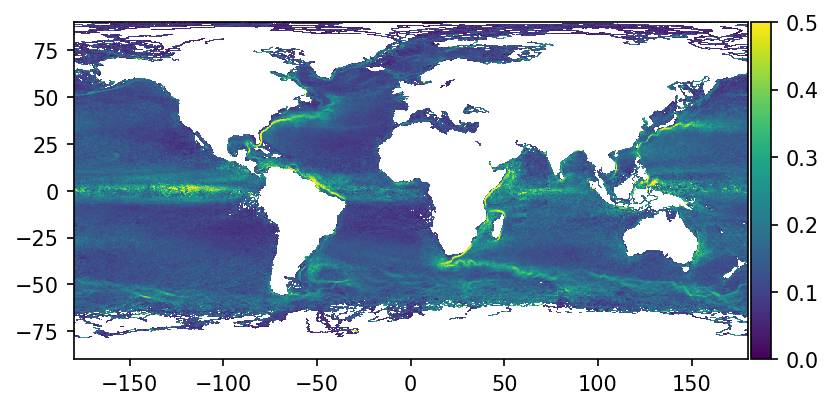

In [24]:
x_c = np.convolve(lon, [0.5, 0.5], mode='valid')
y_c = np.convolve(lat, [0.5, 0.5], mode='valid')

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,aspect='equal')
pcm = ax.pcolormesh(x_c, y_c, ret.statistic.T, vmin=0, vmax=0.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
fig.colorbar(pcm, cax=cax);

## Extracting a given region

In [25]:
def retrieve_region_pd(df, lon: list = None, lat: list = None, time: list = None):
    mask = functools.reduce(np.logical_and, 
                            (
                                df.longitude > lon[0], 
                                df.longitude < lon[1],
                                df.latitude > lat[0],
                                df.latitude < lat[1],
                                df.time > day0,
                                df.time < day1,
                            )
                           )
    
    # this should work but crashes the kernel applying the where()
    return df.loc[mask]      

In [26]:
%%time

lon = [-98, -78]
lat = [18, 31]
day0 = datetime(2015,1,1)
day1 = datetime(2020,12,31)
time = [day0, day1]
df_subset = retrieve_region_pd(df, lon, lat, time)

CPU times: user 12.3 ms, sys: 12.1 ms, total: 24.3 ms
Wall time: 32.3 ms


In [35]:
df.index.values.compute()

KeyError: "['obs'] not in index"

In [27]:
%%time

df_subset.compute()

KeyError: "['obs'] not in index"

## Single statistic per trajectory

In [36]:
np.sum(df['ids'] == 2578).compute()

5137

In [37]:
# mean of all values of a certain trajectory
df[df['ids'] == 2578].mean().compute()

/Users/pmiron/miniforge3/envs/clouddrift/lib/python3.10/site-packages/dask/dataframe/core.py:1944: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  meta = self._meta_nonempty.mean(axis=axis, skipna=skipna)


KeyError: "['obs'] not in index"

In [38]:
%%time

df.groupby("ids").sst.mean().compute()

KeyError: "['obs'] not in index"

In [39]:
%%time
a = df.groupby("ids").sst.apply(lambda x: np.nanmean(x)).compute()

<timed exec>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result


KeyError: "['obs'] not in index"

In [40]:
a

NameError: name 'a' is not defined

In [ ]:
a[68249260]

In [ ]:
np.where((a.index == 68249260).compute())

In [ ]:
a.iloc[17319]

In [20]:
%%time
b = df.groupby("ids").ve.apply(lambda x: np.fft.fft(x)).compute()

CPU times: user 37.4 ms, sys: 20.4 ms, total: 57.8 ms
Wall time: 56.3 ms


<timed exec>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result


In [25]:
# plot random fft
sig = b.iloc[1000]
N = len(sig)
t = np.linspace(0, N*1/24, N)

sp = np.fft.fft(sig)
freq = np.fft.fftfreq(len(t), d=1/24)

plt.plot(freq, sp.real)

AttributeError: 'Series' object has no attribute 'iloc'

In [ ]:
# aggregation can be used to calculate multiple functions

In [30]:
%%time

df.groupby("ids").ve.agg([np.max, np.min, np.mean, np.std]).compute()

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.57 GiB -- Worker memory limit: 9.31 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.63 GiB -- Worker memory limit: 9.31 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.63 GiB -- Worker memory limit: 9.31 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

CPU times: user 2.14 s, sys: 768 ms, total: 2.91 s
Wall time: 41.8 s


,amax,amin,mean,std
ids,,,,
2578,1.3912,-1.0212,0.016376,0.302970
2582,0.6155,-0.8061,-0.010888,0.143363
2583,0.2733,-0.2443,0.014034,0.090755
2592,0.2980,-0.3424,-0.030997,0.090660
2612,0.7094,-0.6637,-0.007169,0.123428
...,...,...,...,...
9918736,0.6503,-0.5168,0.116575,0.249683
9918857,1.6131,-0.6928,0.044713,0.275055
9927907,1.3701,-1.0122,0.206177,0.268762
